In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [95]:
data = pd.read_excel('C:/Users/Administrator/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data = data.drop(['interview','second_interview','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,relabel_check
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,N,N
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,N,N
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,N,N
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,N,N
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,N,N


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 17 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null object
english_level           1188 non-null float64
hired_or_not            1188 non-null object
relabel_check           1188 non-null object
dtypes: float64(1), int64(9), object(7)
memory usage: 167.1+ KB


In [97]:
print("應徵總人數", len(data))
print("男性應徵人數", len(data[data['sex']=='M']))
print("男性錄取人數", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')]))
print("男性錄取率", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='M']))
print("女性應徵人數", len(data[data['sex']=='F']))
print("女性錄取人數", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')]))
print("女性錄取率", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='F']))
print("男性應徵人數占比",len(data[data['sex']=='M'])/len(data))
print("女性應徵人數占比",len(data[data['sex']=='F'])/len(data))

應徵總人數 1188
男性應徵人數 412
男性錄取人數 39
男性錄取率 0.09466019417475728
女性應徵人數 776
女性錄取人數 63
女性錄取率 0.08118556701030928
男性應徵人數占比 0.3468013468013468
女性應徵人數占比 0.6531986531986532


In [98]:
# 設定資料集男女比及應徵錄取比
n_pop = 1000000
p_male = 0.3468
p_job_male, p_job_female = 0.0946, 0.0812

gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])
df = pd.DataFrame({'gender' : gender})
df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])
df['found_job'] = df['found_job'].astype(int)

In [99]:
# 檢視資料集
print("男性應徵人數", len(df[df['gender']=='male']))
print("男性錄取人數", len(df[(df['gender']=='male') & (df['found_job']==1)]))
print("男性錄取率", len(df[(df['gender']=='male') & (df['found_job']==1)])/len(df[df['gender']=='male']))
print("女性應徵人數", len(df[df['gender']=='female']))
print("女性錄取人數", len(df[(df['gender']=='female') & (df['found_job']==1)]))
print("女性錄取率", len(df[(df['gender']=='female') & (df['found_job']==1)])/len(df[df['gender']=='female']))
print("男性應徵人數占比",len(df[df['gender']=='male'])/len(df))
print("女性應徵人數占比",len(df[df['gender']=='female'])/len(df))

男性應徵人數 347017
男性錄取人數 32980
男性錄取率 0.0950385715973569
女性應徵人數 652983
女性錄取人數 52817
女性錄取率 0.0808857198426299
男性應徵人數占比 0.347017
女性應徵人數占比 0.652983


In [100]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,600166,52817
male,314037,32980


In [101]:
print("男性錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.mean())
print("男性錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.std())
print("男性未錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.mean())
print("男性未錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.mean())
print("女性錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.std())
print("女性未錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.mean())
print("女性未錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.std())

男性錄取年齡平均 26.53846153846154
男性錄取年齡標準差 3.3938501180048863
男性未錄取年齡平均 27.396782841823057
男性未錄取年齡標準差 4.783842693106973
---------------------------------------------------------------------
女性錄取年齡平均 25.26984126984127
女性錄取年齡標準差 2.806710560059008
女性未錄取年齡平均 26.517531556802243
女性未錄取年齡標準差 4.669111814273186


In [102]:
# 設定資料集年齡分布(待採樣)
mu_job_male, sigma_job_male = 26.5385, 3.3939
mu_no_job_male, sigma_no_job_male = 27.3968, 4.7838

mu_job_female, sigma_job_female = 25.2698, 2.8067
mu_no_job_female, sigma_no_job_female = 26.5175, 4.6691

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_male, sigma_job_male, len(df_male.loc[df_male.found_job == 1])))
df_male.loc[df_male.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_male, sigma_no_job_male, len(df_male.loc[df_male.found_job == 0])))
df_female.loc[df_female.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_female, sigma_job_female, len(df_female.loc[df_female.found_job == 1])))
df_female.loc[df_female.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_female, sigma_no_job_female, len(df_female.loc[df_female.found_job == 0])))

df = df_male.append(df_female)
df['age'] = df['age'].astype(int)

In [103]:
print("男性錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==1)].age.mean())
print("男性錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==1)].age.std())
print("男性未錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==0)].age.mean())
print("男性未錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==0)].age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==1)].age.mean())
print("女性錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==1)].age.std())
print("女性未錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==0)].age.mean())
print("女性未錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==0)].age.std())

男性錄取年齡平均 26.04363250454821
男性錄取年齡標準差 3.408653026647979
男性未錄取年齡平均 26.901416075175856
男性未錄取年齡標準差 4.7965209997680125
---------------------------------------------------------------------
女性錄取年齡平均 24.784217202794554
女性錄取年齡標準差 2.818380657277206
女性未錄取年齡平均 26.010003898921298
女性未錄取年齡標準差 4.677685256373808


In [104]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,26.3
1,25.3


In [105]:
# 設定資料集學歷分布(待採樣)
print("學士人數", len(data[data['highest_education']=='B']))
print("碩士人數", len(data[data['highest_education']=='M']))
print("博士人數", len(data[data['highest_education']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')]))
print("碩士錄取人數", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')]))
print("博士錄取人數", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')]))
print("總錄取人數", len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("碩士錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("博士錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("碩士不錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("博士不錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

學士人數 1024
碩士人數 162
博士人數 2
---------------------------------------------------------------------
學士錄取人數 87
碩士錄取人數 15
博士錄取人數 0
總錄取人數 102
---------------------------------------------------------------------
學士錄取率 0.8529411764705882
碩士錄取率 0.14705882352941177
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8627992633517495
碩士不錄取率 0.13535911602209943
博士不錄取率 0.001841620626151013


In [106]:
educ_class_set = ['B', 'M', 'D']
educ_class_wt_job = [0.8529, 0.1471, 0]
educ_class_wt_no_job = [0.8628, 0.1354, 0.0018]

df.loc[df.found_job == 1, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 1]), p=educ_class_wt_job)
df.loc[df.found_job == 0, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 0]), p=educ_class_wt_no_job)

In [107]:
# 檢視資料集學歷分布
print("學士人數", len(df[df['educ_class']=='B']))
print("碩士人數", len(df[df['educ_class']=='M']))
print("博士人數", len(df[df['educ_class']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(df[(df['educ_class']=='B') & (df['found_job']==1)]))
print("碩士錄取人數", len(df[(df['educ_class']=='M') & (df['found_job']==1)]))
print("博士錄取人數", len(df[(df['educ_class']=='D') & (df['found_job']==1)]))
print("總錄取人數", len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("碩士錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("博士錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("碩士不錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("博士不錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==0)])/len(df[df['found_job']==0]))

學士人數 861650
碩士人數 136734
博士人數 1616
---------------------------------------------------------------------
學士錄取人數 73285
碩士錄取人數 12512
博士錄取人數 0
總錄取人數 85797
---------------------------------------------------------------------
學士錄取率 0.8541673951303659
碩士錄取率 0.14583260486963415
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8623522346787311
碩士不錄取率 0.1358801054032857
博士不錄取率 0.001767659917983205


In [108]:
# 設定婚姻狀況資料分布(待採樣)
print("女性應徵總人數", len(data[data['sex']=='F']))
print("女性已婚總人數", len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("女性未婚總人數", len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("女性錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='Y')]))
print("未錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("女性未錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(data[data['sex']=='M']))
print("男性已婚總人數", len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("男性未婚總人數", len(data[(data['sex']=='M')&(data['marriage']==0)]))
print("已錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("男性錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("未錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("男性未錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("未婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("未婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==0)]))

女性應徵總人數 776
女性已婚總人數 95
女性未婚總人數 681
已錄取女性已婚人數 3
女性錄取者已婚比例 0.047619047619047616
未錄取女性已婚人數 92
女性未錄取者已婚比例 0.12903225806451613
---------------------------------------------------------------------
男性應徵總人數 412
男性已婚總人數 31
男性未婚總人數 381
已錄取男性已婚人數 5
男性錄取者已婚比例 0.1282051282051282
未錄取男性已婚人數 26
男性未錄取者已婚比例 0.06970509383378017
---------------------------------------------------------------------
已婚女性錄取率 0.031578947368421054
未婚女性錄取率 0.0881057268722467
已婚男性錄取率 0.16129032258064516
未婚男性錄取率 0.08923884514435695


In [109]:
# 設定男女婚姻狀況分布
# 男性錄取者已婚比例, 男性未錄取者已婚比例
p_job_male_marriage, p_no_job_male_marriage = 0.12820512, 0.06970509
# 女性錄取者已婚比例, 女性未錄取者已婚比例
p_job_female_marriage, p_no_job_female_marriage = 0.04761904, 0.12903225

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'marriage'] = np.random.choice(['Y', 'N'], size=len(df_male.loc[df_male.found_job == 1]), p=[p_job_male_marriage, 1 - p_job_male_marriage])
df_male.loc[df_male.found_job == 0, 'marriage'] = np.random.choice(['Y', 'N'], size=len(df_male.loc[df_male.found_job == 0]), p=[p_no_job_male_marriage, 1 - p_no_job_male_marriage])
df_female.loc[df_female.found_job == 1, 'marriage'] = np.random.choice(['Y', 'N'], size=len(df_female.loc[df_female.found_job == 1]), p=[p_job_female_marriage, 1 - p_job_female_marriage])
df_female.loc[df_female.found_job == 0, 'marriage'] = np.random.choice(['Y', 'N'], size=len(df_female.loc[df_female.found_job == 0]), p=[p_no_job_female_marriage, 1 - p_no_job_female_marriage])

df = df_male.append(df_female)

In [112]:
# 設定婚姻狀況資料分布
print("女性應徵總人數", len(df[df['gender']=='female']))
print("女性已婚總人數", len(df[(df['gender']=='female')&(df['marriage']=='Y')]))
print("女性未婚總人數", len(df[(df['gender']=='female')&(df['marriage']=='N')]))
print("已錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']=='Y')&(df['found_job']==1)]))
print("女性錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']=='Y')&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['found_job']==1)]))
print("未錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']=='Y')&(df['found_job']==0)]))
print("女性未錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']=='Y')&(df['found_job']==0)])/len(df[(df['gender']=='female')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(df[df['gender']=='male']))
print("男性已婚總人數", len(df[(df['gender']=='male')&(df['marriage']=='Y')]))
print("男性未婚總人數", len(df[(df['gender']=='male')&(df['marriage']=='N')]))
print("已錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']=='Y')&(df['found_job']==1)]))
print("男性錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']=='Y')&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("未錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']=='Y')&(df['found_job']==0)]))
print("男性未錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']=='Y')&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']=='Y')&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']=='Y')]))
print("未婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']=='N')&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']=='N')]))
print("已婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']=='Y')&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']=='Y')]))
print("未婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']=='N')&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']=='N')]))

女性應徵總人數 652983
女性已婚總人數 80026
女性未婚總人數 572957
已錄取女性已婚人數 2511
女性錄取者已婚比例 0.04754151125584566
未錄取女性已婚人數 77515
女性未錄取者已婚比例 0.12915593352505808
---------------------------------------------------------------------
男性應徵總人數 347017
男性已婚總人數 26078
男性未婚總人數 320939
已錄取男性已婚人數 4232
男性錄取者已婚比例 0.12832019405700423
未錄取男性已婚人數 21846
男性未錄取者已婚比例 0.06956505125192254
---------------------------------------------------------------------
已婚女性錄取率 0.03137730237672756
未婚女性錄取率 0.08780065519751046
已婚男性錄取率 0.16228238361837563
未婚男性錄取率 0.08957465437357255


In [113]:
# 檢視資料集借貸與錄取與否關係
print("有借貸者人數", len(data[data['loan']==1]))
print("有借貸且信用正常且錄取者", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='Y')]))
print("有借貸但信用異常且錄取者", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='Y')]))
print("無借貸且錄取者", len(data[(data['loan']==0)&(data['hired_or_not']=='Y')]))
print("有借貸且異常者占有信貸者比例", len(data[(data['loan']==1)&(data['loan_status']==0)])/len(data[data['loan']==1]))
print("---------------------------------------------------------------------")
print("有信貸者錄取率", len(data[(data['loan']==1)&(data['hired_or_not']=='Y')])/len(data[data['loan']==1]))
print("無信貸者錄取率", len(data[(data['loan']==0)&(data['hired_or_not']=='Y')])/len(data[data['loan']==0]))
print("---------------------------------------------------------------------")
print("錄取者有信貸比例", len(data[(data['loan']==1)&(data['hired_or_not']=='Y')])/len(data[(data['hired_or_not']=='Y')]))
print("未錄取者有信貸比例", len(data[(data['loan']==1)&(data['hired_or_not']=='N')])/len(data[(data['hired_or_not']=='N')]))

有借貸者人數 276
有借貸且信用正常且錄取者 28
有借貸但信用異常且錄取者 0
無借貸且錄取者 74
有借貸且異常者占有信貸者比例 0.014492753623188406
---------------------------------------------------------------------
有信貸者錄取率 0.10144927536231885
無信貸者錄取率 0.08114035087719298
---------------------------------------------------------------------
錄取者有信貸比例 0.27450980392156865
未錄取者有信貸比例 0.2283609576427256


In [114]:
# 建立信貸者資料
p_job_loan, p_no_job_loan = 0.27450980, 0.22836095
df.loc[df.found_job == 1, 'loan'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 1]), p=[p_job_loan, 1 - p_job_loan])
df.loc[df.found_job == 0, 'loan'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 0]), p=[p_no_job_loan, 1 - p_no_job_loan])

In [115]:
# 檢視資料集借貸與錄取與否關係
print("有借貸者人數", len(df[df['loan']==1]))
print("無借貸且錄取者", len(df[(df['loan']==0)&(df['found_job']==1)]))
print("---------------------------------------------------------------------")
print("有信貸者錄取率", len(df[(df['loan']==1)&(df['found_job']==1)])/len(df[df['loan']==1]))
print("無信貸者錄取率", len(df[(df['loan']==0)&(df['found_job']==1)])/len(df[df['loan']==0]))
print("---------------------------------------------------------------------")
print("錄取者有信貸比例", len(df[(df['loan']==1)&(df['found_job']==1)])/len(df[(df['found_job']==1)]))
print("未錄取者有信貸比例", len(df[(df['loan']==1)&(df['found_job']==0)])/len(df[(df['found_job']==0)]))

有借貸者人數 232333
無借貸且錄取者 62453
---------------------------------------------------------------------
有信貸者錄取率 0.10047647127183827
無信貸者錄取率 0.08135428512623312
---------------------------------------------------------------------
錄取者有信貸比例 0.27208410550485446
未錄取者有信貸比例 0.22860240012338617


In [116]:
# 檢視資料集不良信貸者
print("有信貸人數", len(data[(data['loan']==1)]))
print("有信貸且信用正常人數", len(data[(data['loan']==1)&(data['loan_status']==1)]))
print("有信貸但信用不正常人數", len(data[(data['loan']==1)&(data['loan_status']==0)]))
print("---------------------------------------------------------------------")
print("有信貸且信用正常錄取人數", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='Y')]))
print("有信貸且信用正常但未錄取人數", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='N')]))
print("有信貸但信用不正常錄取人數", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='Y')]))
print("有信貸但信用不正常且未錄取人數", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("未錄取者中信用正常者佔比", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='N')])/len(data[(data['loan']==1)&(data['hired_or_not']=='N')]))
print("未錄取者中信用不正常者佔比", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='N')])/len(data[(data['loan']==1)&(data['hired_or_not']=='N')]))

有信貸人數 276
有信貸且信用正常人數 272
有信貸但信用不正常人數 4
---------------------------------------------------------------------
有信貸且信用正常錄取人數 28
有信貸且信用正常但未錄取人數 244
有信貸但信用不正常錄取人數 0
有信貸但信用不正常且未錄取人數 4
---------------------------------------------------------------------
未錄取者中信用正常者佔比 0.9838709677419355
未錄取者中信用不正常者佔比 0.016129032258064516


In [151]:
# 設定信貸狀況分布
# 未錄取信用狀況良好者
p_no_job_loan_good = 0.98387096

df_loan = df[df['loan']==1]
df_no_loan = df[df['loan']==0]

df_loan.loc[df_loan.found_job == 1, 'loan_status'] = np.random.choice([1, 0], size=len(df_loan.loc[df_loan.found_job == 1]), p=[1, 0])
df_loan.loc[df_loan.found_job == 0, 'loan_status'] = np.random.choice([1, 0], size=len(df_loan.loc[df_loan.found_job == 0]), p=[p_no_job_loan_good, 1-p_no_job_loan_good])
    
df = df_loan.append(df_no_loan)

df['loan_status'] = df['loan_status'].fillna(1)

In [152]:
# 檢視資料集不良信貸者
print("有信貸人數", len(df[(df['loan']==1)]))
print("有信貸且信用正常人數", len(df[(df['loan']==1)&(df['loan_status']==1)]))
print("有信貸但信用不正常人數", len(df[(df['loan']==1)&(df['loan_status']==0)]))
print("---------------------------------------------------------------------")
print("有信貸且信用正常錄取人數", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==1)]))
print("有信貸且信用正常但未錄取人數", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==0)]))
print("有信貸但信用不正常錄取人數", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==1)]))
print("有信貸但信用不正常且未錄取人數", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("未錄取者中信用正常者佔比", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==0)])/len(df[(df['loan']==1)&(df['found_job']==0)]))
print("未錄取者中信用不正常者佔比", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==0)])/len(df[(df['loan']==1)&(df['found_job']==0)]))

有信貸人數 232333
有信貸且信用正常人數 228909
有信貸但信用不正常人數 3424
---------------------------------------------------------------------
有信貸且信用正常錄取人數 23344
有信貸且信用正常但未錄取人數 205565
有信貸但信用不正常錄取人數 0
有信貸但信用不正常且未錄取人數 3424
---------------------------------------------------------------------
未錄取者中信用正常者佔比 0.9836163625836767
未錄取者中信用不正常者佔比 0.016383637416323347


In [119]:
# 檢視服役狀況
print("役畢總人數", len(data[(data['sex']=='M')&(data['military_status']==1)]))
print("待畢總人數", len(data[(data['sex']=='M')&(data['military_status']==0)]))
print("錄取者中役畢人數", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='Y')]))
print("錄取者中未畢人數", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='Y')]))
print("未錄取者中役畢人數", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='N')]))
print("未錄取者中未畢人數", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------")
print("錄取者中役畢占比", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("錄取者中未畢占比", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("未錄取者中役畢占比", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))
print("未錄取者中未畢占比", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))

役畢總人數 399
待畢總人數 13
錄取者中役畢人數 38
錄取者中未畢人數 1
未錄取者中役畢人數 361
未錄取者中未畢人數 12
---------------------------------------------------------
錄取者中役畢占比 0.9743589743589743
錄取者中未畢占比 0.02564102564102564
未錄取者中役畢占比 0.967828418230563
未錄取者中未畢占比 0.032171581769437


In [120]:
# 設定資料集服役情況
p_job_miliarty_status, p_no_job_military_status = 0.97435897, 0.96782841

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'military_status'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 1]), p=[p_job_miliarty_status, 1-p_job_miliarty_status])
df_male.loc[df_male.found_job == 0, 'military_status'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 0]), p=[p_no_job_military_status, 1-p_no_job_military_status])
df_female.loc[:,'military_status'] = 1

df = df_male.append(df_female)

In [121]:
# 檢視服役狀況
print("役畢總人數", len(df[(df['gender']=='male')&(df['military_status']==1)]))
print("待畢總人數", len(df[(df['gender']=='male')&(df['military_status']==0)]))
print("錄取者中役畢人數", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==1)]))
print("錄取者中未畢人數", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==1)]))
print("未錄取者中役畢人數", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==0)]))
print("未錄取者中未畢人數", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==0)]))
print("---------------------------------------------------------")
print("錄取者中役畢占比", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("錄取者中未畢占比", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("未錄取者中役畢占比", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))
print("未錄取者中未畢占比", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))

役畢總人數 336111
待畢總人數 10906
錄取者中役畢人數 32153
錄取者中未畢人數 827
未錄取者中役畢人數 303958
未錄取者中未畢人數 10079
---------------------------------------------------------
錄取者中役畢占比 0.9749241964827168
錄取者中未畢占比 0.025075803517283203
未錄取者中役畢占比 0.9679050557736827
未錄取者中未畢占比 0.03209494422631728


In [122]:
print("原住民身分總人數", len(data[data['aboriginal']==1]))
print("錄取者屬原住民身分者", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='Y')]))
print("未錄取者屬原住民身分者", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------")
print("錄取者屬原住民身分者占比", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='Y')])/len(data[(data['hired_or_not']=='Y')]))
print("未錄取者屬原住民身分者占比", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='N')])/len(data[(data['hired_or_not']=='N')]))

原住民身分總人數 10
錄取者屬原住民身分者 1
未錄取者屬原住民身分者 9
---------------------------------------------------------
錄取者屬原住民身分者占比 0.00980392156862745
未錄取者屬原住民身分者占比 0.008287292817679558


In [123]:
# 設定資料集原住民身分
p_job_aboriginal, p_no_job_aboriginal = 0.00980392, 0.00828729

df.loc[df.found_job == 1, 'aboriginal'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 1]), p=[p_job_aboriginal, 1-p_job_aboriginal])
df.loc[df.found_job == 0, 'aboriginal'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 0]), p=[p_no_job_aboriginal, 1-p_no_job_aboriginal])

In [124]:
print("原住民身分總人數", len(df[df['aboriginal']==1]))
print("錄取者屬原住民身分者", len(df[(df['aboriginal']==1)&(df['found_job']==1)]))
print("未錄取者屬原住民身分者", len(df[(df['aboriginal']==1)&(df['found_job']==0)]))
print("---------------------------------------------------------")
print("錄取者屬原住民身分者占比", len(df[(df['aboriginal']==1)&(df['found_job']==1)])/len(df[(df['found_job']==1)]))
print("未錄取者屬原住民身分者占比", len(df[(df['aboriginal']==1)&(df['found_job']==0)])/len(df[(df['found_job']==0)]))

原住民身分總人數 8321
錄取者屬原住民身分者 834
未錄取者屬原住民身分者 7487
---------------------------------------------------------
錄取者屬原住民身分者占比 0.009720619602083988
未錄取者屬原住民身分者占比 0.008189647157141247


In [125]:
# 檢視資料集 BMI 分布
data.loc[:,'bmi'] = (data['weight'] / (data['height']/100 * data['height']/100)).round(1)
print("錄取男性bmi平均", data[(data['sex']=='M')&(data['hired_or_not']=='Y')].bmi.mean())
print("錄取男性bmi標準差", data[(data['sex']=='M')&(data['hired_or_not']=='Y')].bmi.std())
print("未錄取男性bmi平均", data[(data['sex']=='M')&(data['hired_or_not']=='N')].bmi.mean())
print("未錄取男性bmi標準差", data[(data['sex']=='M')&(data['hired_or_not']=='N')].bmi.std())
print("---------------------------------------------------------")
print("錄取女性bmi平均", data[(data['sex']=='F')&(data['hired_or_not']=='Y')].bmi.mean())
print("錄取女性bmi標準差", data[(data['sex']=='F')&(data['hired_or_not']=='Y')].bmi.std())
print("未錄取女性bmi平均", data[(data['sex']=='F')&(data['hired_or_not']=='N')].bmi.mean())
print("未錄取女性bmi標準差", data[(data['sex']=='F')&(data['hired_or_not']=='N')].bmi.std())

錄取男性bmi平均 23.474358974358978
錄取男性bmi標準差 2.583624336054209
未錄取男性bmi平均 22.98739946380696
未錄取男性bmi標準差 3.2864133706349055
---------------------------------------------------------
錄取女性bmi平均 19.603174603174608
錄取女性bmi標準差 1.7807182543232611
未錄取女性bmi平均 20.42272089761572
未錄取女性bmi標準差 2.564294567958626


In [126]:
# 設定資料集BMI分布
mu_job_male_bmi, mu_job_female_bmi = 23.47435897, 19.60317460
sigma_job_male_bmi, sigma_job_female_bmi = 2.58362433, 1.78071825
mu_no_job_male_bmi, mu_no_job_female_bmi = 22.98739946, 20.42272089
sigma_no_job_male_bmi, sigma_no_job_female_bmi = 3.28641337, 2.56429456

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'bmi'] = np.floor(np.random.normal(mu_job_male_bmi, sigma_job_male_bmi, len(df_male.loc[df_male.found_job == 1])))
df_male.loc[df_male.found_job == 0, 'bmi'] = np.floor(np.random.normal(mu_no_job_male_bmi, sigma_no_job_male_bmi, len(df_male.loc[df_male.found_job == 0])))
df_female.loc[df_female.found_job == 1, 'bmi'] = np.floor(np.random.normal(mu_job_female_bmi, sigma_job_female_bmi, len(df_female.loc[df_female.found_job == 1])))
df_female.loc[df_female.found_job == 0, 'bmi'] = np.floor(np.random.normal(mu_no_job_female_bmi, sigma_no_job_female_bmi, len(df_female.loc[df_female.found_job == 0])))

df = df_male.append(df_female)
df.head()

,age,educ_class,found_job,gender,loan,loan_status,marriage,military_status,aboriginal,bmi
3,22,B,0,male,1.0,1.0,N,1.0,0.0,18.0
22,27,B,0,male,1.0,1.0,N,1.0,0.0,23.0
34,32,B,0,male,1.0,1.0,N,1.0,0.0,24.0
51,19,M,0,male,1.0,0.0,N,1.0,0.0,20.0
66,26,B,0,male,1.0,1.0,N,1.0,0.0,20.0


In [127]:
# 檢視資料集各學歷分布情況
print("等級1學歷錄取者人數", len(data[(data['highest_school_level']==1)&(data['hired_or_not']=='Y')]))
print("等級2學歷錄取者人數", len(data[(data['highest_school_level']==2)&(data['hired_or_not']=='Y')]))
print("等級3學歷錄取者人數", len(data[(data['highest_school_level']==3)&(data['hired_or_not']=='Y')]))
print("等級4學歷錄取者人數", len(data[(data['highest_school_level']==4)&(data['hired_or_not']=='Y')]))
print("等級5學歷錄取者人數", len(data[(data['highest_school_level']==5)&(data['hired_or_not']=='Y')]))
print("等級6學歷錄取者人數", len(data[(data['highest_school_level']==6)&(data['hired_or_not']=='Y')]))
print("等級7學歷錄取者人數", len(data[(data['highest_school_level']==7)&(data['hired_or_not']=='Y')]))
print("---------------------------------------------------------")
print("等級1學歷錄取者占比", len(data[(data['highest_school_level']==1)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級2學歷錄取者占比", len(data[(data['highest_school_level']==2)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級3學歷錄取者占比", len(data[(data['highest_school_level']==3)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級4學歷錄取者占比", len(data[(data['highest_school_level']==4)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級5學歷錄取者占比", len(data[(data['highest_school_level']==5)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級6學歷錄取者占比", len(data[(data['highest_school_level']==6)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級7學歷錄取者占比", len(data[(data['highest_school_level']==7)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------")
print("等級1學歷不錄取者占比", len(data[(data['highest_school_level']==1)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級2學歷不錄取者占比", len(data[(data['highest_school_level']==2)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級3學歷不錄取者占比", len(data[(data['highest_school_level']==3)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級4學歷不錄取者占比", len(data[(data['highest_school_level']==4)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級5學歷不錄取者占比", len(data[(data['highest_school_level']==5)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級6學歷不錄取者占比", len(data[(data['highest_school_level']==6)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級7學歷不錄取者占比", len(data[(data['highest_school_level']==7)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

等級1學歷錄取者人數 2
等級2學歷錄取者人數 1
等級3學歷錄取者人數 21
等級4學歷錄取者人數 49
等級5學歷錄取者人數 3
等級6學歷錄取者人數 20
等級7學歷錄取者人數 6
---------------------------------------------------------
等級1學歷錄取者占比 0.0196078431372549
等級2學歷錄取者占比 0.00980392156862745
等級3學歷錄取者占比 0.20588235294117646
等級4學歷錄取者占比 0.4803921568627451
等級5學歷錄取者占比 0.029411764705882353
等級6學歷錄取者占比 0.19607843137254902
等級7學歷錄取者占比 0.058823529411764705
---------------------------------------------------------
等級1學歷不錄取者占比 0.027624309392265192
等級2學歷不錄取者占比 0.09760589318600368
等級3學歷不錄取者占比 0.24125230202578268
等級4學歷不錄取者占比 0.356353591160221
等級5學歷不錄取者占比 0.06906077348066299
等級6學歷不錄取者占比 0.16482504604051565
等級7學歷不錄取者占比 0.0432780847145488


In [128]:
# 設定資料集最高學歷分布
p_job_highest_school = [0.01960784, 0.00980392, 0.20588235, 0.48039215, 0.02941176, 0.19607843, 0.05882355]
p_no_job_ahighest_school = [0.02762430, 0.09760589, 0.24125230, 0.35635359, 0.06906077, 0.16482504, 0.04327811]

df.loc[df.found_job == 1, 'highest_school_level'] = np.random.choice([1, 2, 3, 4, 5, 6, 7], size=len(df.loc[df.found_job == 1]), p=p_job_highest_school)
df.loc[df.found_job == 0, 'highest_school_level'] = np.random.choice([1, 2, 3, 4, 5, 6, 7], size=len(df.loc[df.found_job == 0]), p=p_no_job_ahighest_school)

In [129]:
# 各學歷分布情況
print("等級1學歷錄取者人數", len(df[(df['highest_school_level']==1)&(df['found_job']==1)]))
print("等級2學歷錄取者人數", len(df[(df['highest_school_level']==2)&(df['found_job']==1)]))
print("等級3學歷錄取者人數", len(df[(df['highest_school_level']==3)&(df['found_job']==1)]))
print("等級4學歷錄取者人數", len(df[(df['highest_school_level']==4)&(df['found_job']==1)]))
print("等級5學歷錄取者人數", len(df[(df['highest_school_level']==5)&(df['found_job']==1)]))
print("等級6學歷錄取者人數", len(df[(df['highest_school_level']==6)&(df['found_job']==1)]))
print("等級7學歷錄取者人數", len(df[(df['highest_school_level']==7)&(df['found_job']==1)]))
print("---------------------------------------------------------")
print("等級1學歷錄取者占比", len(df[(df['highest_school_level']==1)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級2學歷錄取者占比", len(df[(df['highest_school_level']==2)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級3學歷錄取者占比", len(df[(df['highest_school_level']==3)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級4學歷錄取者占比", len(df[(df['highest_school_level']==4)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級5學歷錄取者占比", len(df[(df['highest_school_level']==5)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級6學歷錄取者占比", len(df[(df['highest_school_level']==6)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級7學歷錄取者占比", len(df[(df['highest_school_level']==7)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------")
print("等級1學歷不錄取者占比", len(df[(df['highest_school_level']==1)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級2學歷不錄取者占比", len(df[(df['highest_school_level']==2)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級3學歷不錄取者占比", len(df[(df['highest_school_level']==3)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級4學歷不錄取者占比", len(df[(df['highest_school_level']==4)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級5學歷不錄取者占比", len(df[(df['highest_school_level']==5)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級6學歷不錄取者占比", len(df[(df['highest_school_level']==6)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級7學歷不錄取者占比", len(df[(df['highest_school_level']==7)&(df['found_job']==0)])/len(df[df['found_job']==0]))

等級1學歷錄取者人數 1737
等級2學歷錄取者人數 912
等級3學歷錄取者人數 17677
等級4學歷錄取者人數 41205
等級5學歷錄取者人數 2574
等級6學歷錄取者人數 16588
等級7學歷錄取者人數 5104
---------------------------------------------------------
等級1學歷錄取者占比 0.0202454631280814
等級2學歷錄取者占比 0.010629742298681771
等級3學歷錄取者占比 0.2060328449712694
等級4學歷錄取者占比 0.48026154760655965
等級5學歷錄取者占比 0.030001048987726844
等級6學歷錄取者占比 0.1933400934764619
等級7學歷錄取者占比 0.059489259531219044
---------------------------------------------------------
等級1學歷不錄取者占比 0.02745889042149282
等級2學歷不錄取者占比 0.09744006528090589
等級3學歷不錄取者占比 0.24179531241967048
等級4學歷不錄取者占比 0.3559461082494807
等級5學歷不錄取者占比 0.06875606402516728
等級6學歷不錄取者占比 0.16516244203967828
等級7學歷不錄取者占比 0.04344111756360458


In [130]:
# 檢視資料集英文程度分布情況
print("等級1錄取者人數", len(data[(data['english_level']==1)&(data['hired_or_not']=='Y')]))
print("等級2錄取者人數", len(data[(data['english_level']==2)&(data['hired_or_not']=='Y')]))
print("等級3錄取者人數", len(data[(data['english_level']==3)&(data['hired_or_not']=='Y')]))
print("等級4錄取者人數", len(data[(data['english_level']==4)&(data['hired_or_not']=='Y')]))
print("等級5錄取者人數", len(data[(data['english_level']==5)&(data['hired_or_not']=='Y')]))
print("---------------------------------------------------------")
print("等級1錄取者占比", len(data[(data['english_level']==1)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級2錄取者占比", len(data[(data['english_level']==2)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級3錄取者占比", len(data[(data['english_level']==3)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級4錄取者占比", len(data[(data['english_level']==4)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("等級5錄取者占比", len(data[(data['english_level']==5)&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------")
print("等級1不錄取者占比", len(data[(data['english_level']==1)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級1不錄取者占比", len(data[(data['english_level']==2)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級1不錄取者占比", len(data[(data['english_level']==3)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級1不錄取者占比", len(data[(data['english_level']==4)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("等級1不錄取者占比", len(data[(data['english_level']==5)&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

等級1錄取者人數 2
等級2錄取者人數 30
等級3錄取者人數 53
等級4錄取者人數 15
等級5錄取者人數 2
---------------------------------------------------------
等級1錄取者占比 0.0196078431372549
等級2錄取者占比 0.29411764705882354
等級3錄取者占比 0.5196078431372549
等級4錄取者占比 0.14705882352941177
等級5錄取者占比 0.0196078431372549
---------------------------------------------------------
等級1不錄取者占比 0.014732965009208104
等級1不錄取者占比 0.4429097605893186
等級1不錄取者占比 0.4521178637200737
等級1不錄取者占比 0.07366482504604052
等級1不錄取者占比 0.013812154696132596


In [131]:
# 設定資料集最高學歷分布
p_job_english_level = [0.01960784, 0.29411764, 0.51960784, 0.14705882, 0.01960786]
p_no_job_english_level = [0.01473296, 0.44290976, 0.45211786, 0.07366482, 0.0165746]

df.loc[df.found_job == 1, 'english_level'] = np.random.choice([1, 2, 3, 4, 5], size=len(df.loc[df.found_job == 1]), p=p_job_english_level)
df.loc[df.found_job == 0, 'english_level'] = np.random.choice([1, 2, 3, 4, 5], size=len(df.loc[df.found_job == 0]), p=p_no_job_english_level)

In [132]:
# 檢視英文程度分布情況
print("等級1錄取者人數", len(df[(df['english_level']==1)&(df['found_job']==1)]))
print("等級2錄取者人數", len(df[(df['english_level']==2)&(df['found_job']==1)]))
print("等級3錄取者人數", len(df[(df['english_level']==3)&(df['found_job']==1)]))
print("等級4錄取者人數", len(df[(df['english_level']==4)&(df['found_job']==1)]))
print("等級5錄取者人數", len(df[(df['english_level']==5)&(df['found_job']==1)]))
print("---------------------------------------------------------")
print("等級1錄取者占比", len(df[(df['english_level']==1)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級2錄取者占比", len(df[(df['english_level']==2)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級3錄取者占比", len(df[(df['english_level']==3)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級4錄取者占比", len(df[(df['english_level']==4)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("等級5錄取者占比", len(df[(df['english_level']==5)&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------")
print("等級1不錄取者占比", len(df[(df['english_level']==1)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級1不錄取者占比", len(df[(df['english_level']==2)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級1不錄取者占比", len(df[(df['english_level']==3)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級1不錄取者占比", len(df[(df['english_level']==4)&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("等級1不錄取者占比", len(df[(df['english_level']==5)&(df['found_job']==0)])/len(df[df['found_job']==0]))

等級1錄取者人數 1682
等級2錄取者人數 25012
等級3錄取者人數 44913
等級4錄取者人數 12533
等級5錄取者人數 1657
---------------------------------------------------------
等級1錄取者占比 0.01960441507278809
等級2錄取者占比 0.29152534470902247
等級3錄取者占比 0.5234798419525158
等級4錄取者占比 0.1460773686725643
等級5錄取者占比 0.019313029593109318
---------------------------------------------------------
等級1不錄取者占比 0.014785556380803826
等級1不錄取者占比 0.4433960509864877
等級1不錄取者占比 0.4515102225654477
等級1不錄取者占比 0.07385121247687877
等級1不錄取者占比 0.016456957590382005


In [133]:
# 檢視資料集畢業狀況分布情況
print("輟學錄取者人數", len(data[(data['highest_graduation']=='D')&(data['hired_or_not']=='Y')]))
print("肄業錄取者人數", len(data[(data['highest_graduation']=='I')&(data['hired_or_not']=='Y')]))
print("畢業錄取者人數", len(data[(data['highest_graduation']=='Y')&(data['hired_or_not']=='Y')]))
print("輟學未錄取者人數", len(data[(data['highest_graduation']=='D')&(data['hired_or_not']=='N')]))
print("肄業未錄取者人數", len(data[(data['highest_graduation']=='I')&(data['hired_or_not']=='N')]))
print("畢業未錄取者人數", len(data[(data['highest_graduation']=='Y')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------")
print("肄業錄取者占比", len(data[(data['highest_graduation']=='I')&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("肄業錄取者占比", len(data[(data['highest_graduation']=='Y')&(data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------")
print("輟學不錄取者占比", len(data[(data['highest_graduation']=='D')&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("肄業不錄取者占比", len(data[(data['highest_graduation']=='I')&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("畢業不錄取者占比", len(data[(data['highest_graduation']=='Y')&(data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

輟學錄取者人數 0
肄業錄取者人數 10
畢業錄取者人數 92
輟學未錄取者人數 4
肄業未錄取者人數 62
畢業未錄取者人數 1020
---------------------------------------------------------
肄業錄取者占比 0.09803921568627451
肄業錄取者占比 0.9019607843137255
---------------------------------------------------------
輟學不錄取者占比 0.003683241252302026
肄業不錄取者占比 0.0570902394106814
畢業不錄取者占比 0.9392265193370166


In [134]:
# 設定資料集最高學歷分布
p_job_highest_graduation = [0.09803921, 0.90196079]
p_no_job_highest_graduation = [0.00368324, 0.05709023, 0.93922653]

df.loc[df.found_job == 1, 'highest_graduation'] = np.random.choice(['I','Y'], size=len(df.loc[df.found_job == 1]), p=p_job_highest_graduation)
df.loc[df.found_job == 0, 'highest_graduation'] = np.random.choice(['D','I','Y'], size=len(df.loc[df.found_job == 0]), p=p_no_job_highest_graduation)

In [135]:
# 檢視畢業狀況分布情況
print("輟學錄取者人數", len(df[(df['highest_graduation']=='D')&(df['found_job']==1)]))
print("肄業錄取者人數", len(df[(df['highest_graduation']=='I')&(df['found_job']==1)]))
print("畢業錄取者人數", len(df[(df['highest_graduation']==1)&(df['found_job']==1)]))
print("輟學未錄取者人數", len(df[(df['highest_graduation']=='D')&(df['found_job']==0)]))
print("肄業未錄取者人數", len(df[(df['highest_graduation']=='I')&(df['found_job']==0)]))
print("畢業未錄取者人數", len(df[(df['highest_graduation']==1)&(df['found_job']==0)]))
print("---------------------------------------------------------")
print("肄業錄取者占比", len(df[(df['highest_graduation']=='I')&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("肄業錄取者占比", len(df[(df['highest_graduation']=='Y')&(df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------")
print("輟學不錄取者占比", len(df[(df['highest_graduation']=='D')&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("肄業不錄取者占比", len(df[(df['highest_graduation']=='I')&(df['found_job']==0)])/len(df[df['found_job']==0]))
print("畢業不錄取者占比", len(df[(df['highest_graduation']=='Y')&(df['found_job']==0)])/len(df[df['found_job']==0]))

輟學錄取者人數 0
肄業錄取者人數 8227
畢業錄取者人數 0
輟學未錄取者人數 3513
肄業未錄取者人數 51786
畢業未錄取者人數 0
---------------------------------------------------------
肄業錄取者占比 0.09588913365269182
肄業錄取者占比 0.9041108663473082
---------------------------------------------------------
輟學不錄取者占比 0.0038426913934870043
肄業不錄取者占比 0.05664606219843951
畢業不錄取者占比 0.9395112464080735


In [136]:
df.head()

,age,educ_class,found_job,gender,loan,loan_status,marriage,military_status,aboriginal,bmi,highest_school_level,english_level,highest_graduation
3,22,B,0,male,1.0,1.0,N,1.0,0.0,18.0,3.0,2.0,Y
22,27,B,0,male,1.0,1.0,N,1.0,0.0,23.0,3.0,4.0,Y
34,32,B,0,male,1.0,1.0,N,1.0,0.0,24.0,4.0,3.0,Y
51,19,M,0,male,1.0,0.0,N,1.0,0.0,20.0,4.0,3.0,Y
66,26,B,0,male,1.0,1.0,N,1.0,0.0,20.0,7.0,2.0,Y


In [137]:
print("女性應徵者錄取率", len(df[(df['gender']=='female')&(df['found_job']==1)])/len(df[df['gender']=='female']))
print("男性應徵者錄取率", len(df[(df['gender']=='male')&(df['found_job']==1)])/len(df[df['gender']=='male']))
print("---------------------------------------------------------")
print("已婚應徵者錄取率", len(df[(df['marriage']=='Y')&(df['found_job']==1)])/len(df[df['marriage']=='Y']))
print("未婚應徵者錄取率", len(df[(df['marriage']=='N')&(df['found_job']==1)])/len(df[df['marriage']=='N']))
print("---------------------------------------------------------")
print("未婚女性應徵者錄取率", len(df[(df['gender']=='female')&(df['found_job']==1)&(df['marriage']=='N')])/len(df[(df['gender']=='female')&(df['marriage']=='N')]))
print("已婚女性應徵者錄取率", len(df[(df['gender']=='female')&(df['found_job']==1)&(df['marriage']=='Y')])/len(df[(df['gender']=='female')&(df['marriage']=='Y')]))
print("---------------------------------------------------------")
print("未婚男性應徵者錄取率", len(df[(df['gender']=='male')&(df['found_job']==1)&(df['marriage']=='N')])/len(df[(df['gender']=='male')&(df['marriage']=='N')]))
print("已婚男性應徵者錄取率", len(df[(df['gender']=='male')&(df['found_job']==1)&(df['marriage']=='Y')])/len(df[(df['gender']=='male')&(df['marriage']=='Y')]))

女性應徵者錄取率 0.0808857198426299
男性應徵者錄取率 0.0950385715973569
---------------------------------------------------------
已婚應徵者錄取率 0.06355085576415592
未婚應徵者錄取率 0.08843758110563198
---------------------------------------------------------
未婚女性應徵者錄取率 0.08780065519751046
已婚女性應徵者錄取率 0.03137730237672756
---------------------------------------------------------
未婚男性應徵者錄取率 0.08957465437357255
已婚男性應徵者錄取率 0.16228238361837563


In [138]:
# 資料集儲存
df.to_excel("recruit_train_test.xlsx")

# 模型訓練

In [148]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)

def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())

def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale

def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred

def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob

def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [139]:
df.head()

,age,educ_class,found_job,gender,loan,loan_status,marriage,military_status,aboriginal,bmi,highest_school_level,english_level,highest_graduation
3,22,B,0,male,1.0,1.0,N,1.0,0.0,18.0,3.0,2.0,Y
22,27,B,0,male,1.0,1.0,N,1.0,0.0,23.0,3.0,4.0,Y
34,32,B,0,male,1.0,1.0,N,1.0,0.0,24.0,4.0,3.0,Y
51,19,M,0,male,1.0,0.0,N,1.0,0.0,20.0,4.0,3.0,Y
66,26,B,0,male,1.0,1.0,N,1.0,0.0,20.0,7.0,2.0,Y


# 將男女資料分開來處理並訓練模型

In [153]:
# 女性做婚姻狀態檢查
df_female = df[df['gender']=='female']
df_female = df_female.drop('gender', axis=1)
print(len(df_female))
df_female.head()

652983


,age,educ_class,found_job,loan,loan_status,marriage,military_status,aboriginal,bmi,highest_school_level,english_level,highest_graduation
0,35,B,0,1.0,1.0,N,1.0,0.0,20.0,6.0,3.0,Y
4,28,B,0,1.0,1.0,N,1.0,0.0,21.0,3.0,3.0,Y
13,29,M,0,1.0,1.0,Y,1.0,0.0,20.0,7.0,1.0,Y
19,28,B,0,1.0,1.0,N,1.0,0.0,28.0,5.0,2.0,I
23,32,B,0,1.0,1.0,N,1.0,0.0,24.0,4.0,3.0,Y


# Convert to AIF360 format

In [154]:
df_female_onehot = pd.concat([df_female[['found_job', 'age', 'loan', 'loan_status', 'military_status', 'aboriginal', 'highest_school_level', 'english_level', 'bmi']], 
                        pd.get_dummies(df_female[['educ_class', 'highest_graduation', 'marriage']])], axis=1)
df_female_onehot.head()

,found_job,age,loan,loan_status,military_status,aboriginal,highest_school_level,english_level,bmi,educ_class_B,educ_class_D,educ_class_M,highest_graduation_D,highest_graduation_I,highest_graduation_Y,marriage_N,marriage_Y
0,0,35,1.0,1.0,1.0,0.0,6.0,3.0,20.0,1,0,0,0,0,1,1,0
4,0,28,1.0,1.0,1.0,0.0,3.0,3.0,21.0,1,0,0,0,0,1,1,0
13,0,29,1.0,1.0,1.0,0.0,7.0,1.0,20.0,0,0,1,0,0,1,0,1
19,0,28,1.0,1.0,1.0,0.0,5.0,2.0,28.0,1,0,0,0,1,0,1,0
23,0,32,1.0,1.0,1.0,0.0,4.0,3.0,24.0,1,0,0,0,0,1,1,0


In [155]:
df_female_aif = BinaryLabelDataset(df=df_female_onehot.drop('marriage_N', axis=1), label_names=['found_job'], protected_attribute_names=['marriage_Y'])

In [156]:
privileged_group = [{'marriage_Y': 0}]
unprivileged_group = [{'marriage_Y': 1}]

In [158]:
df_orig_trn, df_orig_val, df_orig_tst = df_female_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(326491, 15), (195895, 15), (130597, 15)]


# Compute fairness metric on original dataset

In [159]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.648


# Train model on original dataset

In [160]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

In [161]:
thresh_arr = np.linspace(0.01, 0.5, 100)

In [162]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)

In [163]:
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


In [164]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.646
1-min(DI, 1/DI): 0.936


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


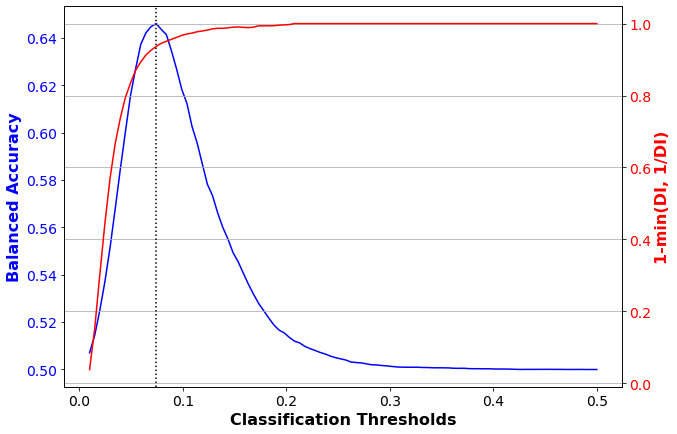

In [165]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on original dataset

In [166]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)

dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

In [167]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.074
Best balanced accuracy: 0.647
1-min(DI, 1/DI): 0.931


# Bias mitigation

In [168]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [169]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


# Train model on transformed dataset

In [170]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [171]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)

In [172]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


In [173]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.069
Best balanced accuracy: 0.633
1-min(DI, 1/DI): 0.018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


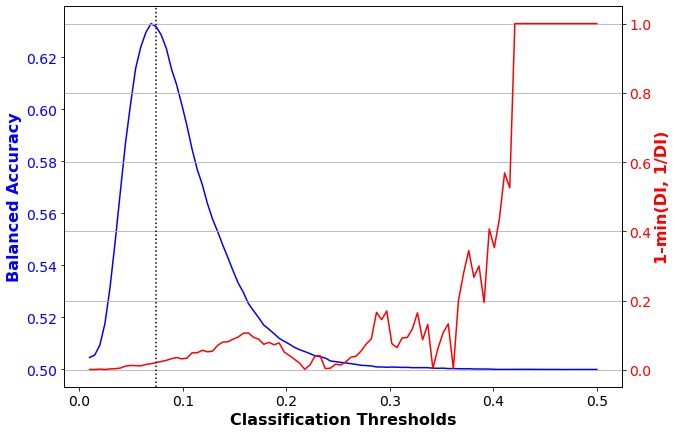

In [174]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on transformed dataset

In [175]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

In [176]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.069
Best balanced accuracy: 0.636
1-min(DI, 1/DI): 0.038


In [177]:
# 男性做婚姻狀態檢查
df_male = df[df['gender']=='male']
df_male = df_male.drop('gender', axis=1)
print(len(df_male))
df_male.head()

347017


,age,educ_class,found_job,loan,loan_status,marriage,military_status,aboriginal,bmi,highest_school_level,english_level,highest_graduation
3,22,B,0,1.0,1.0,N,1.0,0.0,18.0,3.0,2.0,Y
22,27,B,0,1.0,1.0,N,1.0,0.0,23.0,3.0,4.0,Y
34,32,B,0,1.0,1.0,N,1.0,0.0,24.0,4.0,3.0,Y
51,19,M,0,1.0,1.0,N,1.0,0.0,20.0,4.0,3.0,Y
66,26,B,0,1.0,1.0,N,1.0,0.0,20.0,7.0,2.0,Y


# Convert to AIF360 format

In [178]:
df_male_onehot = pd.concat([df_male[['found_job', 'age', 'loan', 'loan_status', 'military_status', 'aboriginal', 'highest_school_level', 'english_level', 'bmi']], 
                        pd.get_dummies(df_male[['educ_class', 'highest_graduation', 'marriage']])], axis=1)
df_male_onehot.head()

,found_job,age,loan,loan_status,military_status,aboriginal,highest_school_level,english_level,bmi,educ_class_B,educ_class_D,educ_class_M,highest_graduation_D,highest_graduation_I,highest_graduation_Y,marriage_N,marriage_Y
3,0,22,1.0,1.0,1.0,0.0,3.0,2.0,18.0,1,0,0,0,0,1,1,0
22,0,27,1.0,1.0,1.0,0.0,3.0,4.0,23.0,1,0,0,0,0,1,1,0
34,0,32,1.0,1.0,1.0,0.0,4.0,3.0,24.0,1,0,0,0,0,1,1,0
51,0,19,1.0,1.0,1.0,0.0,4.0,3.0,20.0,0,0,1,0,0,1,1,0
66,0,26,1.0,1.0,1.0,0.0,7.0,2.0,20.0,1,0,0,0,0,1,1,0


In [179]:
df_male_aif = BinaryLabelDataset(df=df_male_onehot.drop('marriage_Y', axis=1), label_names=['found_job'], protected_attribute_names=['marriage_N'])

In [180]:
privileged_group = [{'marriage_Y': 1}]
unprivileged_group = [{'marriage_Y': 0}]

In [181]:
df_orig_trn, df_orig_val, df_orig_tst = df_male_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(173508, 15), (104105, 15), (69404, 15)]


# Compute fairness metric on original dataset

In [182]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)